In [1]:
import torch
from supervoice_valle import SupervoceNARModel, Tokenizer
from train.dataset import load_sampler
from IPython.display import Audio, display
import matplotlib.pyplot as plt
from vocos import Vocos

In [2]:
vocos = Vocos.from_pretrained("charactr/vocos-encodec-24khz").to("cuda")
tokenizer = Tokenizer("./tokenizer_text.model")
sampler = load_sampler("./external_datasets/libriheavy/libriheavy_cuts_small.jsonl.gz", "./external_datasets/libriheavy-encodec/", 1, tokenizer)
model = SupervoceNARModel()
checkpoint = torch.load("./output/valle-35.pt", map_location = "cpu")
model.load_state_dict(checkpoint['model'])
# model = model.to(torch.float16)
model = model.to("cuda")
model.eval()
step = checkpoint['step']
print(checkpoint['step'])

/home/steve/miniconda3/envs/gym/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


486000


In [3]:
audio, text = sampler()
print(audio[0], text[0])
encoded = audio[0]
text = text[0]
# id = "./external_datasets/libriheavy-encodec/9774/extermination_american_bison_1503_librivox_64kb_mp3/exterminationamericanbison_12_hornaday_64kb_99"
# with open(id + ".txt", 'r') as file:
#     text = file.read()
#     text = tokenizer.encode(text)
# encoded = torch.load(id + ".pt")

tensor([[ 408, 1019,  835,  ...,  738, 1017,  106],
        [ 544,  544,  302,  ...,  424,  913,  424],
        [ 989,   36,  819,  ...,   36,  653,  819],
        ...,
        [ 435,  931,   41,  ...,  881,   41,  986],
        [ 977,  977,  782,  ...,  772,  570,  570],
        [1012,  475,  975,  ...,  518,  701,  628]]) tensor([ 551,   52,   42,  121,   78,   65, 1547, 1382,  109,   28, 1119,   12,
         500,  548,   52,   13,  498,  224,  373,   27,   52,  139,  309, 1075,
          71,   42,   52,  134,  185,   12,  438,  217,  107,   52,  217,  282,
        2495,   33,  309,  255,   10,   52,  490,   78, 1499,   84,   71, 2127,
          10,   52,  348,  306,  319,  309,  340, 2318,   13,   52,  319,  217,
         107,  384,  380,   52,   42,   71,  541,   12])


In [4]:
def decode(tokens):
    features = vocos.codes_to_features(tokens.to("cuda"))
    bandwidth_id = torch.tensor([2]).to("cuda")  # 6 kbps
    return vocos.decode(features, bandwidth_id=bandwidth_id)
display(Audio(data=decode(encoded).cpu(), rate=24000))
print(encoded.shape)

torch.Size([8, 699])


In [5]:
condition_text = text.to("cuda")
condition_audio = encoded[:,:75*3].to("cuda")
audio = encoded[:,75*3:].to("cuda")
predicted = [audio[0]]
# print(audio[0].to("cuda"))
for i in range(1, 8):
    p = model(
        condition_text = [condition_text], 
        condition_audio = [condition_audio],
        audio = [torch.stack(predicted)],
        codec = [i]
    )

    p = p[0]
    p = torch.nn.functional.softmax(p, dim=-1)
    # print(p.shape)

    # for j in range(len(audio[i])):
    #     print(p[j][audio[i][j]].item(), torch.max(p[j]).item())

    # Top-3
    # p = p[0]
    # v, _ = torch.topk(p.unsqueeze(0), 10)
    # v = v.squeeze(0)
    # p[p < v[:, [-1]]] = -float('Inf')

    # Sample
    # p = torch.nn.functional.softmax(p, dim=-1)
    # p = torch.multinomial(p, num_samples=1)
    # p = p.squeeze(-1)

    p = torch.argmax(p, dim=-1, keepdim=True)
    p = p.squeeze(-1)

    # print("inference")
    # print(p)
    # print(audio[i])
    predicted.append(p)
predicted = torch.stack(predicted)
predicted = torch.cat([condition_audio, predicted], dim = 1)
display(Audio(data=decode(predicted).cpu(), rate=24000))

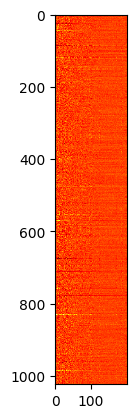

In [6]:
plt.imshow(model.positional_embedding_text.weight.T[:,:200].cpu().detach().numpy(), cmap='hot', interpolation='nearest')
plt.show()

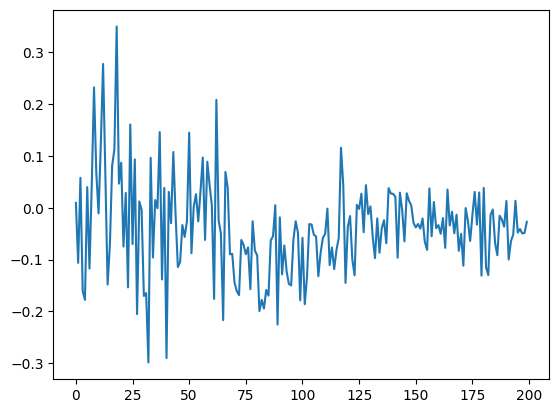

In [12]:
plt.plot(model.positional_embedding_text.weight.T[2,0:200].cpu().detach().numpy())
plt.show()

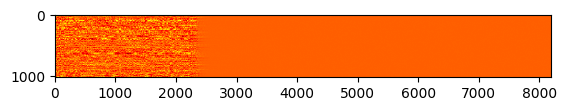

In [8]:
plt.imshow(model.positional_embedding_audio.weight.T.cpu().detach().numpy(), cmap='hot', interpolation='nearest')
plt.show()

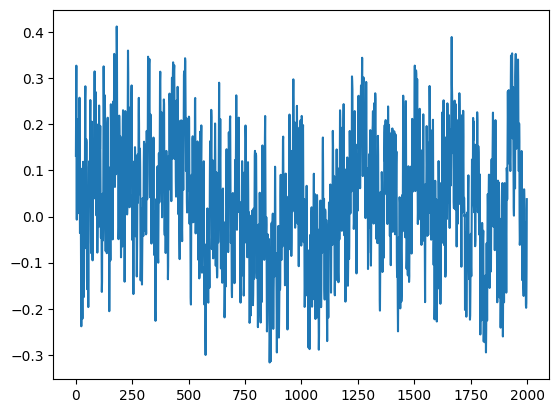

In [9]:
plt.plot(model.positional_embedding_audio.weight.T[0, 0:2000].cpu().detach().numpy())
plt.show()

In [10]:
# for i in range(step - 40000, step, 5000):
#     checkpoint = torch.load("./output/valle-23." + str(i) + ".pt", map_location = "cpu")
#     model.load_state_dict(checkpoint['model'])

#     condition_text = text
#     condition_audio = encoded[:,:75*3]
#     audio = encoded[:,75*3:]
#     predicted = [audio[0]]
#     for i in range(1, 8):
#         p = model(
#             condition_text = [condition_text], 
#             condition_audio = [condition_audio],
#             audio = [torch.stack(predicted)],
#             codec = [i]
#         )
#         p = p[0]
#         p = torch.nn.functional.softmax(p, dim=-1)
#         p = torch.argmax(p, dim=-1, keepdim=True)
#         p = p.squeeze(-1)
#         predicted.append(p.cpu())
#     predicted = torch.stack(predicted)
#     predicted = torch.cat([condition_audio, predicted], dim = 1)
#     display(Audio(data=decode(predicted).cpu(), rate=24000))